<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Generation-of-mock-microbial-community-for-16S-analysis" data-toc-modified-id="Generation-of-mock-microbial-community-for-16S-analysis-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Generation of mock microbial community for 16S analysis</a></span></li><li><span><a href="#Set-up" data-toc-modified-id="Set-up-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Set up</a></span></li><li><span><a href="#Simulate-environment" data-toc-modified-id="Simulate-environment-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Simulate environment</a></span><ul class="toc-item"><li><span><a href="#Gutmock-and-vagimock" data-toc-modified-id="Gutmock-and-vagimock-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Gutmock and vagimock</a></span></li><li><span><a href="#mockrobiota" data-toc-modified-id="mockrobiota-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>mockrobiota</a></span><ul class="toc-item"><li><span><a href="#Cut-the--Vregions" data-toc-modified-id="Cut-the--Vregions-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Cut the  Vregions</a></span></li><li><span><a href="#Filter-and-downloand" data-toc-modified-id="Filter-and-downloand-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Filter and downloand</a></span></li></ul></li><li><span><a href="#Create-the-environment-for-each-sample-of-each-mock" data-toc-modified-id="Create-the-environment-for-each-sample-of-each-mock-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Create the environment for each sample of each mock</a></span></li><li><span><a href="#Create-environment-samples-for-mockrobiota" data-toc-modified-id="Create-environment-samples-for-mockrobiota-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Create environment samples for mockrobiota</a></span></li></ul></li><li><span><a href="#Generate-simulate-reads:-ART" data-toc-modified-id="Generate-simulate-reads:-ART-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Generate simulate reads: ART</a></span></li><li><span><a href="#Qiime-Processing" data-toc-modified-id="Qiime-Processing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Qiime Processing</a></span><ul class="toc-item"><li><span><a href="#Demultiplex" data-toc-modified-id="Demultiplex-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Demultiplex</a></span></li><li><span><a href="#Sequence-quality-control-and-feature-table-construction" data-toc-modified-id="Sequence-quality-control-and-feature-table-construction-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Sequence quality control and feature table construction</a></span></li><li><span><a href="#FeatureTable-and-FeatureData-summaries" data-toc-modified-id="FeatureTable-and-FeatureData-summaries-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>FeatureTable and FeatureData summaries</a></span></li></ul></li><li><span><a href="#Map-sequences-that-match-to-taxonomies" data-toc-modified-id="Map-sequences-that-match-to-taxonomies-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Map sequences that match to taxonomies</a></span><ul class="toc-item"><li><span><a href="#Clusterize-environment-with-cdhit" data-toc-modified-id="Clusterize-environment-with-cdhit-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Clusterize environment with cdhit</a></span></li><li><span><a href="#Generate-truesh-taxonomy-file" data-toc-modified-id="Generate-truesh-taxonomy-file-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Generate truesh-taxonomy file</a></span></li></ul></li></ul></div>

# Generation of mock microbial community for 16S analysis

This notebook has been though to generate in-silico mock communities for 16S analysis. It consist in several steps:

- Simulate a specific sample environment (e.g. vagina, gut, mouth) from an abundancy table that contains the taxon and its frequency
- Generate in-silico reads from the environment
- Process the in-silico reads with Qiime2 to obtain rep-seps 

The mock community directory structure will looks like the following:
```
out_dir/
├── db_name/ # database name
│   └── db_version/ # database version
│       └── db_similarity/ # otu % similarity if applicable. If using a database that has not been clustered, use "100-otus"
│           ├── env-identifiers.tsv # environment identifiers associated with each mock community member
│           ├── env-seqs.fasta # environment sequences
│           ├── expected-taxonomy.tsv # per-sample taxonomic abundances (species level)
│           └── table.L6-taxa.biom # per-sample taxonomic abundances (species level) in biom format
            └── source/
                ├── abundancy_table # generation of abundancy table
                ├── art # fastq simulation
                │   ├── single or paired/ # depending on your choice
                │   │    ├── read1.fq # simulated reads
                │   │    └── fastq/ # simulated fastq reads compressed and with formatted name
                └── qiime2
                    └── single or paired/ # depending on your choice
                        ├── demux.qza
                        ├── table.qza
                        └── rep_seqs.qza
```

# Set up

In [1]:
from qiime2 import Artifact
from qiime2 import Metadata
import qiime2.plugins.metadata.actions as metadata_actions
import qiime2.plugins.feature_table.actions as feature_table_actions
import qiime2.plugins.taxa.actions as taxa_actions
import qiime2.plugins.dada2.actions as dada2_actions

import pandas as pd
import numpy as np
from IPython.display import display
import os
from os.path import join, basename, dirname, exists, splitext
import pickle
from Bio import SeqIO

from joblib import Parallel, delayed
import random
import multiprocessing as mp

%matplotlib inline
%load_ext autoreload

# Custom functions
import mock_community
from utils import check_dir
import utils
import new_approach
import parse_cdhit

import networkx as nx
import matplotlib as plt
from tax_credit import mock_quality

import logging

Change the below cell according to your needs.

In [2]:
# V region
v_regions = ['V4', 'V3-V4']
paired = {
    'V4' : False,
    'V3-V4': True
}
length_reads = {
    'V4' : 200,
    'V3-V4': 250
}
mlength_reads = {
    'V4' : 200,
    'V3-V4': 450
}

# Mock-communities
mock_names = ['vagimock', 'gutmock']

# Working directory
pwd = os.getcwd()

# Database files
created_dir = "new_approach/created_db"
original_dir = "new_approach/original_db"

db, db_name, db_version, db_similarity = {},{}, {}, {}
db_out_files, abun_tab = {}, {}

for v_region in v_regions:
    db[v_region] = {f'gsrv_{v_region}':
          {'seq':join(created_dir, f'gsrv_{v_region}_seqs.qza'),
          'taxa':join(created_dir, f'gsrv_{v_region}_taxa.qza')}
    }

    ## Database parameters
    db_name[v_region] = f'gsrv_{v_region}'
    db_version[v_region] = f'gsrv_{v_region}'
    db_similarity[v_region] = "NS-otus"

    ## Database output files
    db_out_files[v_region] = {
        mocknames: join(mocknames, db_name[v_region], db_version[v_region],
                    db_similarity[v_region]) for mocknames in mock_names}

    # Input: abundance table
    abun_tab[v_region] = { mockname: join(
        mockname,'abundance_table', 'expected-taxonomy.tsv'
    ) for mockname in mock_names}

In [3]:
# Generate directory
for v_region in v_regions:
    for key, outdir in db_out_files[v_region].items():
        check_dir(outdir)

# Simulate environment

## Gutmock and vagimock

In [4]:
db_unqza, abundance_tabs = {}, {}

for v_region in v_regions:
    # Choose the decompressed version of the database
    db_unqza[v_region] = { key:{
        'seq': items['seq'].replace('qza', 'fasta'), 
        'taxa': items['taxa'].replace('qza', 'txt')
    } for key, items in db[v_region].items() }

    # Read the abundance_tables for each mock-community
    abundance_tabs[v_region] = { mockname : pd.read_csv(
        abun_file, sep = "\t", header = 0, index_col = None
    ) for mockname, abun_file in abun_tab[v_region].items()}

## mockrobiota

In [3]:
db_unqza, abundance_tabs = {}, {}
mockrobiota_src = "mockrobiota/src"
mockrobiota_files = {
    'seq': join(mockrobiota_src, "mockrobiota_seqs.fasta"),
    'taxa': join(mockrobiota_src, "mockrobiota_taxa.txt")
}

feature_tab = {}

for v_region in v_regions:
    db_unqza[v_region], abundance_tabs[v_region] = {}, {}
    # Output directory
    db_out_files[v_region]['mockrobiota'] = join(
        'mockrobiota', f'mockrobiota_{v_region}', 
        f'mockrobiota_{v_region}', 'NS-otus')
    check_dir(db_out_files[v_region]['mockrobiota'])
    
    # Add abundance table
    abun_tab[v_region]['mockrobiota'] = join(
        mockrobiota_src, 'expected-taxonomy.tsv')

    # Read the abundance_tables for each mock-community
    abundance_tabs[v_region]['mockrobiota'] = pd.read_csv(
        abun_tab[v_region]['mockrobiota'], sep = "\t", 
        header = 0, index_col = None)
    
    # Read the feature tables  
    feature_tab[v_region] = {'mockrobiota': pd.read_csv(
        join(mockrobiota_src, "expected-featuretab.tsv"), sep = "\t", 
        header = 0, index_col = 'ID')}
    

In [5]:
db_out_files

{'V4': {'vagimock': 'vagimock/gsrv_V4/gsrv_V4/NS-otus',
  'gutmock': 'gutmock/gsrv_V4/gsrv_V4/NS-otus',
  'mockrobiota': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus'},
 'V3-V4': {'vagimock': 'vagimock/gsrv_V3-V4/gsrv_V3-V4/NS-otus',
  'gutmock': 'gutmock/gsrv_V3-V4/gsrv_V3-V4/NS-otus',
  'mockrobiota': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus'}}

In [7]:
abun_tab

{'V4': {'vagimock': 'vagimock/abundance_table/expected-taxonomy.tsv',
  'gutmock': 'gutmock/abundance_table/expected-taxonomy.tsv',
  'mockrobiota': 'mockrobiota/src/expected-taxonomy.tsv'},
 'V3-V4': {'vagimock': 'vagimock/abundance_table/expected-taxonomy.tsv',
  'gutmock': 'gutmock/abundance_table/expected-taxonomy.tsv',
  'mockrobiota': 'mockrobiota/src/expected-taxonomy.tsv'}}

### Cut the  Vregions

In [4]:
v_primers = utils.get_vregion_primers()
v_length = utils.get_vregion_lengths()

In [5]:
%%time
%autoreload

out_seqs_file = {}

src_dirout = join(mockrobiota_src, 'extracted_regions')
check_dir(src_dirout)

for v_region in v_regions:
    out_fasta_pref = join(
        src_dirout, f'mockrobiota_{v_region}') 

    out_seqs_file[v_region] = new_approach.extract_region(
        seqs = mockrobiota_files['seq'], prefix_db = out_fasta_pref,
        f_primer = v_primers[v_region]['f'],
        r_primer = v_primers[v_region]['r'],
        min_length = v_length[v_region]['min'], 
        max_length=v_length[v_region]['max'], 
        threads=30, 
        force=False, output_formats = ['fasta'])

CPU times: user 1.31 s, sys: 381 ms, total: 1.69 s
Wall time: 5.34 s


### Filter and downloand  

Keep only entries with both sequence and taxonomy information

In [6]:
db_mockro = {}


for v_region in v_regions:

    db_mockro[v_region] = utils.load_db_from_files(
        taxa_path = mockrobiota_files['taxa'], 
        seqs_path = out_seqs_file[v_region]['fasta'])
    
    taxa_out = join(
            src_dirout, f'mockrobiota_{v_region}_taxa.txt')
    seqs_out = join(
            src_dirout, f'mockrobiota_{v_region}_seqs.fasta')
    
    utils.download_db_from_dict(
        db_mockro[v_region],
        taxa_out_file = taxa_out,
        seqs_out_file = seqs_out 
    )
    
    db_unqza[v_region]['mockrobiota'] = {
        'seq': seqs_out, 'taxa':taxa_out }

13 entries without sequence or taxa information were deleted


## Create the environment for each sample of each mock

In [38]:
# Simulate the environment
env_fastas, env_abun_dfs = {}, {}

for v_region in v_regions:
    env_fastas[v_region] = {}
    env_abun_dfs[v_region] = {}
    
    for key, df in abundance_tabs[v_region].items():
        env_f, env_abun = mock_community.simulate_env(
            abun_table = df, db = db_unqza[v_region], 
            db_name = db_name[v_region], 
            out_dir = db_out_files[v_region][key], force=False)
        env_fastas[v_region][key] = env_f
        env_abun_dfs[v_region][key] = env_abun

In [39]:
env_abun_dfs

{'V4': {'vagimock': {'vagimock00': 'vagimock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_vagimock00.fasta',
   'vagimock01': 'vagimock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_vagimock01.fasta',
   'vagimock02': 'vagimock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_vagimock02.fasta',
   'vagimock03': 'vagimock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_vagimock03.fasta',
   'vagimock04': 'vagimock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_vagimock04.fasta'},
  'gutmock': {'gutmock00': 'gutmock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_gutmock00.fasta',
   'gutmock01': 'gutmock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_gutmock01.fasta',
   'gutmock02': 'gutmock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_gutmock02.fasta',
   'gutmock03': 'gutmock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_gutmock03.fasta',
   'gutmock04': 'gutmock/gsrv_V4/gsrv_V4/NS-otus/env-seqs_gutmock04.fasta'},
  'mockrobiota': {'mockrobiota00': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env-seqs_mockrobiota00.fasta',
   'mockrobiota01': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env-se

Glance over the abundancies obtained after creating the environment

In [40]:
for v_region in v_regions:
    d = env_abun_dfs[v_region]['vagimock'][
        env_abun_dfs[v_region]['vagimock']['Taxon'].str.contains(
            "crispatus")]
    display(d)

,Taxon,vagimock00,vagimock01,vagimock02,vagimock03,vagimock04
6,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.0,126.0,1246.0,4470.0,6121.0


,Taxon,vagimock00,vagimock01,vagimock02,vagimock03,vagimock04
6,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lac...,0.0,126.0,1246.0,4470.0,6121.0


## Create environment samples for mockrobiota

In [7]:
# simulate environment from a feature table
%autoreload
env_fastas, env_abun_dfs = {}, {}

for v_region in v_regions:
    env_fastas[v_region] = {'mockrobiota':{}}
    
    tab = feature_tab[v_region]['mockrobiota']
    env = utils.load_db_from_files(seqs_path = db_unqza[v_region]['mockrobiota']['seq'], 
                                   taxa_path = db_unqza[v_region]['mockrobiota']['taxa'])
    
    outdir = db_out_files[v_region]['mockrobiota']
    
    # donwload env fasta and taxa
    env = {ID: item for ID, item in env.items() if ID in tab.index} #filter only included in the samples
    
    #initialize abundance table
    env_abun_tab = pd.DataFrame(index=abundance_tabs['V4']['mockrobiota']['Taxon'])
    
    
    for sample in tab.columns:
        # output files
        sample_fasta = join(outdir, f"env-seqs_{sample}.fasta")
        sample_identifiers = join(outdir, f"env-identifiers_{sample}.tsv")
        
        ids = list(tab[tab[sample]==1].index)
        sample_env = {ID: item for ID, item in env.items() if ID in ids}
        
        #download sample fasta
        utils.download_db_from_dict(sample_env, seqs_out_file = sample_fasta)
        env_fastas[v_region]['mockrobiota'][sample] = sample_fasta
        
        samp_taxonomies = [utils.join_taxa_lineages(record['taxa']
                            ) for ID, record in sample_env.items()]
        
        # create env-identifiers
        env_identifiers = {}
        for i in sample_env.keys():
            tax = utils.join_taxa_lineages(sample_env[i]['taxa'])
            env_identifiers.setdefault(tax, []).append(i)
        
        # write env-identifiers file
        with open(sample_identifiers, 'w') as fh:
            fh.write(f"Taxa\tAbundance\tIDs\n")
            for tax, ids in env_identifiers.items():
                id_line = ','.join(ids)
                n = len(ids)
                fh.write(f"{tax}\t{n}\t{id_line}\n")
        
        # update env_abundance table
        abun = pd.Series(samp_taxonomies).value_counts().to_frame(
        ).rename(columns={0: sample})
        env_abun_tab = env_abun_tab.join(abun, how='outer').fillna(0)
    
    # download abun_tab
    env_abun_tab = env_abun_tab.reset_index().rename(columns = {'index': 'Taxon'})
    out_abun_tab = join(outdir, 'env_abundance.tsv')
    env_abun_tab.to_csv(out_abun_tab, sep="\t", index=False)
    env_abun_dfs[v_region] = {'mockrobiota': env_abun_tab}

In [8]:
env_fastas

{'V4': {'mockrobiota': {'mockrobiota00': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env-seqs_mockrobiota00.fasta',
   'mockrobiota01': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env-seqs_mockrobiota01.fasta',
   'mockrobiota02': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env-seqs_mockrobiota02.fasta',
   'mockrobiota03': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env-seqs_mockrobiota03.fasta',
   'mockrobiota04': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env-seqs_mockrobiota04.fasta'}},
 'V3-V4': {'mockrobiota': {'mockrobiota00': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env-seqs_mockrobiota00.fasta',
   'mockrobiota01': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env-seqs_mockrobiota01.fasta',
   'mockrobiota02': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env-seqs_mockrobiota02.fasta',
   'mockrobiota03': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env-seqs_mockrobiota03.fasta',
   'mockrob

# Generate simulate reads: ART

Simulate Miseq Illumina Reads with art simulation tools. The function of amplicon simulation is used.

More information [here](https://www.niehs.nih.gov/research/resources/software/biostatistics/art/index.cfm).

In [11]:
%autoreload
art_path = "programs/artbinmountrainier2016.06.05linux64/art_bin_MountRainier/"
art_out_prefixs = {}

for v_region in v_regions:
    art_out_prefixs[v_region] = {}
    
    for key, val in env_fastas[v_region].items():
        art_out_prefixs[v_region][key] = {}


        for sample, path_fasta in val.items():
            dir_out = dirname(path_fasta)
            # Run simulation
            art_out = mock_community.art_simulation(
                input_fasta = path_fasta, output_prefix = sample,
                dir_out = join(dir_out, "source/art/"), 
                seq_method = "MSv1", length = length_reads[v_region],
                mlen = mlength_reads[v_region],
                count = 1, n_samples = 1, paired = paired[v_region], 
                seed=123, force=True, art_path = art_path)

            art_out_prefixs[v_region][key][sample] = art_out


    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 7, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

              Amplicon 5'-end sequencing simulation

Total CPU time used: 0.02

The random seed for the run: 123

Parameters used during run
	Read Length:	200
	'N' genomic regions masking turned off
	# Reads per Amplion:       0
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   MiSeq v1 Length 250 R1 (built-in profile) 

Output files

  FASTQ Sequence File:
	mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/mockrobiota00S01_sample_L001_R1.fq


    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 7, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

  

              Amplicon 5'-end sequencing simulation

Total CPU time used: 0.03

The random seed for the run: 123

Parameters used during run
	Read Length:	200
	'N' genomic regions masking turned off
	# Reads per Amplion:       0
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   MiSeq v1 Length 250 R1 (built-in profile) 

Output files

  FASTQ Sequence File:
	mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/mockrobiota03S01_sample_L001_R1.fq


    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 7, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

              Amplicon 5'-end sequencing simulation

Total CPU time used: 0.02

The random seed for the run: 123

Parameters used during run
	Read Length:	200
	'N' genomic regions masking turned off
	# Reads per Amplion:       0
	Profile Type: 


    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 7, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

             Amplicon paired-end sequencing simulation

Total CPU time used: 0.04

The random seed for the run: 123

Parameters used during run
	Read Length:	250
	'N' genomic regions masking turned off
	# Read Pairs per Amplion:  0
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   MiSeq v1 Length 250 R1 (built-in profile) 
	First Read:   MiSeq v1 Length 250 R2 (built-in profile) 

Output files

  FASTQ Sequence Files:
	 the 1st reads: mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/mockrobiota01S01_sample_L001_R1.fq
	 the 2nd reads: mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/mockrobiota01S01_sample_L001_R2.fq


    ====================ART======

             Amplicon paired-end sequencing simulation

Total CPU time used: 0.05

The random seed for the run: 123

Parameters used during run
	Read Length:	250
	'N' genomic regions masking turned off
	# Read Pairs per Amplion:  0
	Profile Type:             Combined
	ID Tag:                   

Quality Profile(s)
	First Read:   MiSeq v1 Length 250 R1 (built-in profile) 
	First Read:   MiSeq v1 Length 250 R2 (built-in profile) 

Output files

  FASTQ Sequence Files:
	 the 1st reads: mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/mockrobiota02S01_sample_L001_R1.fq
	 the 2nd reads: mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/mockrobiota02S01_sample_L001_R2.fq


    ====================ART====================
             ART_Illumina (2008-2016)          
          Q Version 2.5.8 (June 7, 2016)       
     Contact: Weichun Huang <whduke@gmail.com> 
    -------------------------------------------

             Amplicon paired-end s

In [12]:
art_out_prefixs

{'V4': {'mockrobiota': {'mockrobiota00': ['mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/mockrobiota00S01_sample_L001_R1.fq'],
   'mockrobiota01': ['mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/mockrobiota01S01_sample_L001_R1.fq'],
   'mockrobiota02': ['mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/mockrobiota02S01_sample_L001_R1.fq'],
   'mockrobiota03': ['mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/mockrobiota03S01_sample_L001_R1.fq'],
   'mockrobiota04': ['mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/mockrobiota04S01_sample_L001_R1.fq']}},
 'V3-V4': {'mockrobiota': {'mockrobiota00': ['mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/mockrobiota00S01_sample_L001_R.fq'],
   'mockrobiota01': ['mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/mockrobiota01S01_sample_L001_R.fq'],
   'mockrobiota02': ['mockrobiota/mockrobiota_V

Now, we are going to compress and change name of fastq files from art simulation tools.

In this case, there is one fastq file for each sample (Casava 1.8 format). 

The file name will include the sample identifier and should look like vagi_mock01_sample_L001_R1_001.fastq.gz. The underscore-separated fields in this file name are:

- mock01: the sample identifier (variable),
- sample: the barcode sequence or a barcode identifier (constant),
- L001  : the lane number (constant),
- R1    : the direction of the read (e.g. only R1, because these are single-end reads), and
- 001   : the set number (constant).

Find more info [here](https://docs.qiime2.org/2022.8/tutorials/importing/)

In [13]:
fq_out_dirs = {}

for v_region in v_regions:
    fq_out_dirs[v_region] = {}
    # Compress and change fq names to adapt to Qiime input
    for key, val in art_out_prefixs[v_region].items():
        for sample, path in val.items():
            fq_out_name = [
                mock_community.adapt_art_output_to_qiime(
                    item, paired = paired[v_region], force=True) for item in path]

        fq_out_dirs[v_region][key] = dirname(fq_out_name[0])

In [14]:
fq_out_dirs

{'V4': {'mockrobiota': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/fastq'},
 'V3-V4': {'mockrobiota': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/fastq'}}

# Qiime Processing

## Demultiplex
Demultiplex samples generated with art simulation tools. [Source](https://docs.qiime2.org/2022.8/tutorials/moving-pictures-usage/)

In [15]:
demultiplex = {}

for v_region in v_regions:
    demultiplex[v_region] = {}

    for key, fq_out_dir in fq_out_dirs[v_region].items():
        out_dir = db_out_files[v_region][key]
        demux, demux_viz, qiime_out = mock_community.qiime_demultiplex(
            out_dir = join(out_dir, f"source/qiime2/"), 
            fq_out_dir=fq_out_dir, paired=paired[v_region], force=True)
        demultiplex[v_region][key] = [demux, demux_viz, qiime_out]

qiime tools import --type SampleData[SequencesWithQuality] --input-path mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/fastq --input-format CasavaOneEightSingleLanePerSampleDirFmt --output-path mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/qiime2/single/demux-single-end.qza

Imported mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/art/single/fastq as CasavaOneEightSingleLanePerSampleDirFmt to mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/qiime2/single/demux-single-end.qza
qiime tools import --type SampleData[PairedEndSequencesWithQuality] --input-path mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/fastq --input-format CasavaOneEightSingleLanePerSampleDirFmt --output-path mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/qiime2/paired/demux-paired-end.qza

Imported mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/art/paired/fastq as CasavaOneEightSingleLanePerSampleDirFmt to mockrob

<Figure size 432x288 with 0 Axes>

After demultiplexing, it’s useful to generate a summary of the demultiplexing results. This allows you to determine how many sequences were obtained per sample, and also to get a summary of the distribution of sequence qualities at each position in your sequence data.

In [16]:
for v_region in v_regions:
    print(f"### {v_region} region")
    for key, items in demultiplex[v_region].items():
        demux_viz = items[1]
        display(demux_viz)

### V4 region


<visualization: Visualization uuid: 85a1f7af-f9b3-4318-8a49-f3b132a78f84>

### V3-V4 region


<visualization: Visualization uuid: ae8db9db-6c1e-4189-bfaa-228786585477>

In [17]:
demultiplex

{'V4': {'mockrobiota': [<artifact: SampleData[SequencesWithQuality] uuid: 18016d83-6486-450c-b00f-785cdc2912c9>,
   <visualization: Visualization uuid: 85a1f7af-f9b3-4318-8a49-f3b132a78f84>,
   'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/source/qiime2/single/']},
 'V3-V4': {'mockrobiota': [<artifact: SampleData[PairedEndSequencesWithQuality] uuid: ccda3bbf-8015-4a04-87c2-6d5f43fbc4d9>,
   <visualization: Visualization uuid: ae8db9db-6c1e-4189-bfaa-228786585477>,
   'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/source/qiime2/paired/']}}

## Sequence quality control and feature table construction

In [18]:
%%time
%autoreload
dada2 = {}

for v_region in v_regions:
    dada2[v_region] = {}
    
    for key, items in demultiplex[v_region].items():
        qiime_out = items[2]
        demux = items[0]
        
        print(f"\n### {key} - {v_region} \n")
        table, rep_seqs_sim, stats = mock_community.denoise_dada2(
            qiime_out, key, demux, threads = 30, 
            force = True, paired=paired[v_region])

        dada2[v_region][key] = [table, rep_seqs_sim, stats]


### mockrobiota - V4 

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_single.R /tmp/qiime2-archive-elgsjswh/18016d83-6486-450c-b00f-785cdc2912c9/data /tmp/tmpbry52nva/output.tsv.biom /tmp/tmpbry52nva/track.tsv /tmp/tmpbry52nva 0 0 2.0 2 Inf independent consensus 1.0 30 1000000 NULL 16

R version 4.1.3 (2022-03-10) 


Loading required package: Rcpp


DADA2: 1.22.0 / Rcpp: 1.0.8.3 / RcppParallel: 5.1.5 
1) Filtering .....
2) Learning Error Rates
2e+05 total bases in 1000 reads from 5 samples will be used for learning the error rates.
3) Denoise samples .....
4) Remove chimeras (method = consensus)
5) Report read numbers through the pipeline
6) Write output

### mockrobiota - V3-V4 

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_paired.R /tmp/tmp0ya4fagl/forward /tmp/tmp0ya4fagl/reverse /tmp/tmp0ya4fagl/output.tsv.biom /tmp/tmp0ya4fagl/track.tsv /tmp/tmp0ya4fagl/filt_f /tmp/tmp0ya4fagl/filt_r 0 0 0 0 2.0 2.0 2 12 independent consensus 1.0 30 1000000

R version 4.1.3 (2022-03-10) 


Loading required package: Rcpp


DADA2: 1.22.0 / Rcpp: 1.0.8.3 / RcppParallel: 5.1.5 
1) Filtering .....
2) Learning Error Rates
240250 total bases in 961 reads from 5 samples will be used for learning the error rates.
240250 total bases in 961 reads from 5 samples will be used for learning the error rates.
3) Denoise samples .....
.....
4) Remove chimeras (method = consensus)
6) Write output
CPU times: user 264 ms, sys: 170 ms, total: 434 ms
Wall time: 18.7 s


In [19]:
dada2

{'V4': {'mockrobiota': [<artifact: FeatureTable[Frequency] uuid: 439f7a5c-8d96-423f-8b66-cc975b8aa6d3>,
   <artifact: FeatureData[Sequence] uuid: ea542af7-576c-449d-a55a-abe207e6a8f4>,
   <artifact: SampleData[DADA2Stats] uuid: 4b6e752c-e578-4276-9713-28b76f747e74>]},
 'V3-V4': {'mockrobiota': [<artifact: FeatureTable[Frequency] uuid: 6d5fc11c-3e73-4244-9f8e-54f65f6905f2>,
   <artifact: FeatureData[Sequence] uuid: ae527a96-0636-4ac1-8b02-1f1ccb9e0bdc>,
   <artifact: SampleData[DADA2Stats] uuid: a31a4f47-7e89-44d7-b717-e7bdc43dec96>]}}

In [20]:
for v_region in v_regions:
    stats_vizs = []
    
    for key, items in dada2[v_region].items():
        stats = items[2]
        qiime_out = demultiplex[v_region][key][2]
        
        stats_dada2_md_md = stats.view(Metadata)
        stats_viz, = metadata_actions.tabulate(
            input=stats_dada2_md_md,)
        
        stats_viz.save(
            join(qiime_out, f'stats_{key}') )

        stats_vizs.append(stats_viz)

    for st in stats_vizs:display(st)

<visualization: Visualization uuid: 7a1f1b32-3e3e-4cc7-a8dc-528431a90bf7>

<visualization: Visualization uuid: 8d84bda6-9044-41ac-85fe-fd27e5386bdd>

## FeatureTable and FeatureData summaries
Now, compare the Feature table obtained from the simulation vs the original one.

In [21]:
for v_region in v_regions:
    for key, items in dada2[v_region].items():
        qiime_out = demultiplex[v_region][key][2]

        print(f"\n#####\n## {key}\n#####")  
        # Simulated Table
        print(f"\n#~~~~\n## Simulated Tab\n#~~~~")
        table = items[0]
        table_viz, = feature_table_actions.summarize(
            table=table,
        )
        table_viz.save(join(qiime_out, f'table_{key}'))
        display(table_viz)


#####
## mockrobiota
#####

#~~~~
## Simulated Tab
#~~~~


<visualization: Visualization uuid: cef1dfb8-5e45-48f2-8747-22e2f201adc7>


#####
## mockrobiota
#####

#~~~~
## Simulated Tab
#~~~~


<visualization: Visualization uuid: 8ba83913-332b-483b-b936-f364bc7f1841>

In [22]:
for v_region in v_regions:
    for key, items in dada2[v_region].items():
        qiime_out = demultiplex[v_region][key][2]

        print(f"\n#####\n## {key}\n#####")
        ## Simulated
        # Save rep_seqs in fasta format
        print(f"\n#~~~~\n## Simulated RepSeqs\n#~~~~")
        rep_seqs_sim = items[1]
        rep_seqs_sim.export_data(qiime_out)

        rep_seqs_sim_viz, = feature_table_actions.tabulate_seqs(
            data=rep_seqs_sim,)
        rep_seqs_sim_viz.save(
            join(qiime_out, f"rep_seqs_{key}"))
        display(rep_seqs_sim_viz)


#####
## mockrobiota
#####

#~~~~
## Simulated RepSeqs
#~~~~


<visualization: Visualization uuid: 408c398e-f92d-4048-a596-98b17921c11b>


#####
## mockrobiota
#####

#~~~~
## Simulated RepSeqs
#~~~~


<visualization: Visualization uuid: 6fb23daf-0de5-4199-aca2-9c13e2eab6db>

Above you can see that the original rep-seqs have larger sequence length that the simulated ones (simulated = 200nt). This is because in the databases the minimum length sequence is about 200nt. Therefore, we cannot simulate larger sequences (> 200nt) because some sequences are shorter.

# Map sequences that match to taxonomies

We will map observed mock community sequences, which are technically from unknown organisms, to "trueish" taxonomies, i.e., the most likely taxonomic match given a list of expected sequences derived from the input strains. This serves two purposes:
1. We can then use trueish taxonomies to calculate per-sequence precision/recall scores
2. Mismatch profiles give us a quantitative assessment of the overall "quality" of a mock community (or at least the quality control methods used to process it).

Generate a reference files for the environment. This reference will contain all the sequences and taxa present across all the samples of the environment. It is created by subsetting the original reference database from which the mock-community was created, selecting only the species present in the mock-community.

In [23]:
# mocknames = ['vagimock', 'gutmock', 'mockrobiota']
mocknames = ['mockrobiota']

In [24]:
ref_env = {}

for v_region in v_regions:
    
    ref_env[v_region] = {}
    
    for mockname in mocknames:
        if mockname == 'mockrobiota':
            # Original files of the reference database
            name_db = 'mockrobiota'
        else:
            # Original files of the reference database
            name_db = db_name[v_region]
        
        # Load original database
        or_ref_db = utils.load_db_from_files(
            taxa_path = db_unqza[v_region][name_db]['taxa'], 
            seqs_path = db_unqza[v_region][name_db]['seq'])

        # Filter
        mock_taxa = list(env_abun_dfs[v_region][mockname]['Taxon'])
        or_ref_db_filt = {
            key:items for key, items in or_ref_db.items(
            ) if items['taxa'][6] in ' '.join(mock_taxa)
        }

        # Download
        fasta_out = join(db_out_files[v_region][mockname], 'env_seqs.fasta')
        taxa_out = join(db_out_files[v_region][mockname], 'env_taxa.txt')

        utils.download_db_from_dict(
            or_ref_db_filt, 
            taxa_out_file = taxa_out, 
            seqs_out_file = fasta_out)

        ref_env[v_region][mockname] = [(mockname, fasta_out, taxa_out)]

In [27]:
ref_env

{'V4': {'mockrobiota': [('mockrobiota',
    'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_seqs.fasta',
    'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_taxa.txt')]},
 'V3-V4': {'mockrobiota': [('mockrobiota',
    'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env_seqs.fasta',
    'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env_taxa.txt')]}}

## Clusterize environment with cdhit
Input and output vars

In [28]:
cdhit_out = {}
env_files = {}

for v_region in v_regions:
    print(f"\n### {v_region} region\n")
    
    env_files[v_region] = {
        mockname: {
            'seq': ref_env[v_region][mockname][0][1], 
            'taxa': ref_env[v_region][mockname][0][2] } for mockname in mocknames}

    # Output file
    cdhit_out[v_region] = {
        mockname: join(db_out_files[v_region][mockname], 'env_cluster') for mockname in mocknames}
    print(f"{env_files=}\n\n{cdhit_out=}")


### V4 region

env_files={'V4': {'mockrobiota': {'seq': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_seqs.fasta', 'taxa': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_taxa.txt'}}}

cdhit_out={'V4': {'mockrobiota': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_cluster'}}

### V3-V4 region

env_files={'V4': {'mockrobiota': {'seq': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_seqs.fasta', 'taxa': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_taxa.txt'}}, 'V3-V4': {'mockrobiota': {'seq': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env_seqs.fasta', 'taxa': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env_taxa.txt'}}}

cdhit_out={'V4': {'mockrobiota': 'mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_cluster'}, 'V3-V4': {'mockrobiota': 'mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env_cluster'}}


Clusterize

In [29]:
force = True
identity = 0.99

cdhit_outfiles = {}
cdhit_outfiles_ord = {}

for v_region in v_regions:
    cdhit_outfiles[v_region] = {}
    cdhit_outfiles_ord[v_region] = {}

    for mock in mocknames:
        outfile = f"{cdhit_out[v_region][mock]}-{identity}"
        cdhit_outfiles[v_region][mock] = f"{outfile}.clstr"
        cdhit_outfiles_ord[v_region][mock] = f"{outfile}_ord.clstr"
        seq_fasta = env_files[v_region][mock]['seq']

        if not exists(outfile) or force:
            !time cd-hit-est -i {seq_fasta} -o {outfile} -c {identity} -M 50000 -T 30 -g 1 -d 0

Program: CD-HIT, V4.7 (+OpenMP), Jul 01 2017, 08:43:07
Command: cd-hit-est -i
         mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_seqs.fasta
         -o
         mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_cluster-0.99
         -c 0.99 -M 50000 -T 30 -g 1 -d 0

Started: Fri Feb  3 13:15:23 2023
                            Output                              
----------------------------------------------------------------
total seq: 274
longest and shortest : 254 and 252
Total letters: 69311
Sequences have been sorted

Approximated minimal memory consumption:
Sequence        : 0M
Buffer          : 30 X 12M = 362M
Table           : 2 X 16M = 33M
Miscellaneous   : 4M
Total           : 400M

Table limit with the given memory limit:
Max number of representatives: 4000000
Max number of word counting entries: 6199895426

# comparing sequences from          0  to        274
---------- new table with       98 representatives

      274  finished         98  clusters

Appri

Sort by cluster size

In [30]:
force=True

for v_region in v_regions:
    for mock in mocknames:
        file = cdhit_outfiles[v_region][mock]
        file_ord = cdhit_outfiles_ord[v_region][mock]
        if not exists(file_ord) or force:
            !clstr_sort_by < {file} no > {file_ord}

Import clusters into graphs

In [31]:
graphs = {}

for v_region in v_regions:
    graphs[v_region] = {}
    
    print(f"\n### {v_region} region\n")
    
    # parse cd-hit cluster file
    for mock in mocknames:
        file_ord = cdhit_outfiles_ord[v_region][mock]
        clusters = parse_cdhit.read_cluster(file_ord)
        graphs[v_region][mock] = parse_cdhit.create_graph(clusters)
        print(f"{mock}: {nx.info(graphs[v_region][mock])}")


### V4 region

mockrobiota: Graph with 274 nodes and 176 edges

### V3-V4 region

mockrobiota: Graph with 261 nodes and 168 edges


/tmp/ipykernel_42148/2219536594.py:13: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  print(f"{mock}: {nx.info(graphs[v_region][mock])}")


Add labels to nodes according to taxa file

In [32]:
taxon = ["family", "genus", "species"]

for v_region in v_regions:
    for key, g in graphs[v_region].items():
        # obtain node attributes
        taxonomy, species, genus, family = parse_cdhit.cluster_attributes(
            env_files[v_region][key]['taxa'])
        # Add node attributes
        nx.set_node_attributes(g, taxonomy, 'taxonomy')
        nx.set_node_attributes(g, species, 'species')
        nx.set_node_attributes(g, genus, 'genus')
        nx.set_node_attributes(g, family, 'family')
        graphs[v_region][key] = g

Get clusterized sequences and taxa

In [33]:
%%time
%autoreload
mock_clu = {}
threads=10
force = True
only_centroid = False

for v_region in v_regions:
    
    mock_clu[v_region] = {}
    mock_clu_obj = f"mock_clu_dict-{v_region}-{identity}.pickle"

    if not exists(mock_clu_obj) or force:
        for key, g in graphs[v_region].items():
            args = [(g.subgraph(comp), only_centroid
                    ) for comp in list(nx.connected_components(g))]

            with mp.Pool(processes=threads) as pool:
                try:
                    results = pool.starmap(
                        parse_cdhit.get_taxa_from_cluster, args)
                except:
                    pool.terminate()      
            if only_centroid:
                mock_clu[v_region][key] = {item[0]:item[1] for item in results}
            else:
                mock_clu[v_region][key] = {
                    i:tax.copy() for ids, tax in results for i in ids}

        pickle.dump(mock_clu[v_region], open(mock_clu_obj, 'wb'))
    else:
        mock_clu[v_region] = pickle.load(open(mock_clu_obj, 'rb'))

CPU times: user 155 ms, sys: 198 ms, total: 353 ms
Wall time: 456 ms


Add sequences and check if all the centroids from the fasta file are recorded.

In [34]:
# Append seqs
for v_region in v_regions:
    for mock, env in mock_clu[v_region].items():
        fasta_file = env_files[v_region][mock]['seq']
        print(f"{fasta_file} --> {mock}")

        with open(fasta_file, "r") as seqsfile:
            for record in SeqIO.parse(seqsfile, "fasta"):
                ID = record.id
                seq= record.seq

                if ID in env:
                    env[ID]['seq'] = seq
                else:
                    print(f"{ID} not in {mock}")

mockrobiota/mockrobiota_V4/mockrobiota_V4/NS-otus/env_seqs.fasta --> mockrobiota
mockrobiota/mockrobiota_V3-V4/mockrobiota_V3-V4/NS-otus/env_seqs.fasta --> mockrobiota


Downloand clusters

In [35]:
ref_env = {}
force = True

for v_region in v_regions:
    ref_env[v_region] = {}
    
    for mock, env in mock_clu[v_region].items():
        print(mock)
        # Download as txt and fasta
        taxa_file = join(
            db_out_files[v_region][mock], f"env_taxa_clust-{identity}.txt")
        seqs_file = join(
            db_out_files[v_region][mock], f"env_seqs_clust-{identity}.fasta")
        ref_env[v_region][mock] = [(mock, seqs_file, taxa_file)]

        if not exists(taxa_file) or not exists(seqs_file) or force:
            utils.download_db_from_dict(env, 
                                        taxa_out_file = taxa_file,
                                        seqs_out_file = seqs_file)

mockrobiota
mockrobiota


## Generate truesh-taxonomy file


### V4 region

####
## mockrobiota
####

Guessed taxonomy for 767 of 767 reads (100.0%)


/home/alee_gm/programs/miniconda3/envs/qiime2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


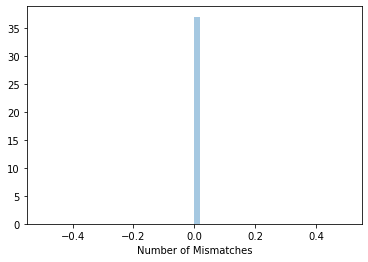

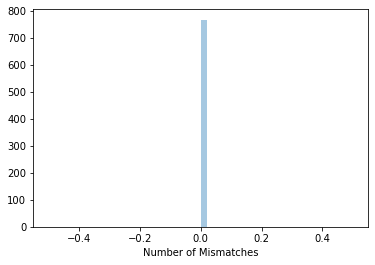


### V3-V4 region

####
## mockrobiota
####

Guessed taxonomy for 588 of 588 reads (100.0%)


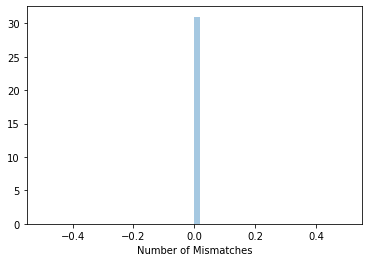

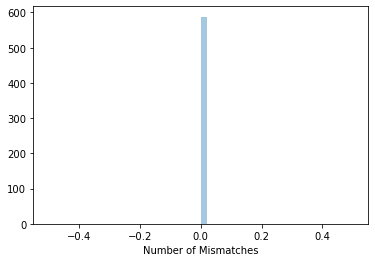

CPU times: user 7.93 s, sys: 11.6 s, total: 19.5 s
Wall time: 10.2 s


In [36]:
%%time
%autoreload

for v_region in v_regions:
    print(f"\n### {v_region} region\n")
    
    for mockname in mocknames:
        print(f"####\n## {mockname}\n####\n")
        # Parameters
        if paired[v_region]:
            read_type = 'paired'
        else:
            read_type = 'single'
        
        observed_sequences = join(
            db_out_files[v_region][mockname], "source/qiime2", 
            read_type, f"rep_seqs_{mockname}.fasta")
        feature_table = join(
            dirname(observed_sequences), f"table_{mockname}.qza")

#         logging.basicConfig(
#             filename=join(db_out_files[mockname],f'debug_exp_{mockname}.log'), format='%(asctime)s %(message)s',
#                         filemode = 'w', level=logging.DEBUG)

        mock_quality.generate_trueish_taxonomies(
            outdir = db_out_files[v_region][mockname], 
            mock_dir_env = db_out_files[v_region][mockname],
            expected_sequences = ref_env[v_region][mockname][0][1], 
            observed_sequences = observed_sequences,
            taxonomy_file_env = ref_env[v_region][mockname][0][2], 
            feature_table = feature_table, mock_name = mockname, 
            without_rev=True, max_mismatches=5, force=True, threads=10
        )